In [60]:
import tensorflow as tf
import cv2
import mediapipe as mp
import ultralytics
import sklearn
import pandas as pd
import numpy as np
import flask

print("TensorFlow:", tf.__version__)
print("OpenCV:", cv2.__version__)
print("Mediapipe:", mp.__version__)
print("Ultralytics YOLO:", ultralytics.__version__)
print("Flask:", flask.__version__)


TensorFlow: 2.18.0
OpenCV: 4.11.0
Mediapipe: 0.10.21
Ultralytics YOLO: 8.3.89
Flask: 3.1.0


/var/folders/rw/7n1dqrds7pl3t6fc5xkq7rl80000gn/T/ipykernel_6660/2236596067.py:14: DeprecationWarning: The '__version__' attribute is deprecated and will be removed in Flask 3.1. Use feature detection or 'importlib.metadata.version("flask")' instead.
  print("Flask:", flask.__version__)


In [62]:
# ✅ Essential Imports
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from tqdm import tqdm
from ultralytics import YOLO
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ✅ Dataset & Feature Extraction Parameters
DATASET_PATH = "cricket_shot"         # Folder containing labeled shot videos (organized by class)
SEQUENCE_LENGTH = 60                  # Frames per sequence for better temporal representation
FRAME_INTERVAL = 1                    # Capture every frame (for rich data extraction)
POSE_KEYPOINTS = 33 * 3               # 33 landmarks * (x, y, z) = 99 pose features
EXTRA_FEATURES = 7                   # Bat (2) + Bat Speed (1) + Bat Angle (1) + Ball (2) + Ball Speed (1)

# ✅ Training Parameters
BATCH_SIZE = 8                        # Smaller batch size → better gradient flow
EPOCHS = 100                          # More epochs → better learning
TEST_SIZE = 0.2                       # 80% train, 20% test
RANDOM_STATE = 42                     # Reproducibility

# ✅ Initialize Mediapipe Pose Estimation
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    min_detection_confidence=0.5
)

# ✅ Initialize YOLOv8 (Try loading custom weights first)
try:
    yolo_model = YOLO("runs/detect/train/weights/best.pt")  # ✅ Replace with your path if different!
    print("✅ Custom YOLOv8 bat/ball detector loaded successfully!")
except Exception as e:
    print(f"⚠️ Custom YOLO weights not found! Using default YOLOv8n weights.\nError: {e}")
    yolo_model = YOLO("yolov8n.pt")  # ✅ Use default weights if custom is missing

# ✅ Collect Class Labels (Subfolder Names)
class_labels = sorted([
    folder for folder in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, folder))
])

# ✅ Display Dataset Info
print("✅ Project Initialized!")
print(f"✅ Shot Classes Detected: {class_labels}")
print(f"✅ Frames per Sequence: {SEQUENCE_LENGTH}")
print(f"✅ Features per Frame (Pose + Bat/Ball): {POSE_KEYPOINTS + EXTRA_FEATURES}")


I0000 00:00:1741942708.277716  217923 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3
W0000 00:00:1741942708.351555  615764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741942708.389801  615770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


⚠️ Custom YOLO weights not found! Using default YOLOv8n weights.
Error: [Errno 2] No such file or directory: 'runs/detect/train/weights/best.pt'
✅ Project Initialized!
✅ Shot Classes Detected: ['Cover_Drive', 'Cut_shot', 'Defence', 'Pull_Shot', 'Sweep_Shot']
✅ Frames per Sequence: 60
✅ Features per Frame (Pose + Bat/Ball): 106


In [63]:
# ✅ Feature Extraction Function (Pose + Bat/Ball + Speed + Angle)

def extract_features(video_path, sequence_length=SEQUENCE_LENGTH, frame_interval=FRAME_INTERVAL):
    """
    Extract features from a single video:
    - Pose Keypoints (Mediapipe)
    - Bat & Ball Detections (YOLOv8)
    - Bat Speed, Bat Angle, Ball Speed
    Returns a feature array of shape (1, sequence_length, feature_len)
    """

    cap = cv2.VideoCapture(video_path)
    features = []
    frame_count = 0

    prev_bat_center, prev_ball_center = None, None

    print(f"📹 Processing video: {video_path}")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process every FRAME_INTERVAL frames
        if frame_count % frame_interval == 0:
            
            # ✅ Mediapipe Pose
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pose_results = pose.process(frame_rgb)

            pose_keypoints = []
            if pose_results.pose_landmarks:
                for lm in pose_results.pose_landmarks.landmark:
                    pose_keypoints.extend([lm.x, lm.y, lm.z])
            else:
                pose_keypoints = [0.0] * POSE_KEYPOINTS

            # ✅ YOLOv8 Bat & Ball Detection
            detections = yolo_model.predict(source=frame, conf=0.3, verbose=False)[0].boxes.data.cpu().numpy()

            bat_center, ball_center = None, None
            for det in detections:
                x1, y1, x2, y2, conf, class_id = det
                cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
                if int(class_id) == 0:  # Bat class
                    bat_center = [cx, cy]
                elif int(class_id) == 1:  # Ball class
                    ball_center = [cx, cy]

            # ✅ Calculate Bat Speed, Bat Angle, Ball Speed
            bat_speed = np.linalg.norm(np.array(bat_center) - np.array(prev_bat_center)) if prev_bat_center and bat_center else 0.0
            ball_speed = np.linalg.norm(np.array(ball_center) - np.array(prev_ball_center)) if prev_ball_center and ball_center else 0.0

            # Bat Angle (relative to right wrist in pose landmarks)
            try:
                wrist_x = pose_keypoints[16 * 3]
                wrist_y = pose_keypoints[16 * 3 + 1]
                bat_angle = np.arctan2(bat_center[1] - wrist_y, bat_center[0] - wrist_x) if bat_center else 0.0
            except:
                bat_angle = 0.0

            prev_bat_center, prev_ball_center = bat_center, ball_center

            # ✅ Combine All Features into a Single Feature Vector for this Frame
            bat_features = bat_center if bat_center else [0.0, 0.0]
            ball_features = ball_center if ball_center else [0.0, 0.0]

            frame_features = pose_keypoints + bat_features + [bat_speed, bat_angle] + ball_features + [ball_speed]
            features.append(frame_features)

        frame_count += 1

        # ✅ Stop when enough frames are collected
        if len(features) >= sequence_length:
            break

    cap.release()

    if len(features) < sequence_length:
        print(f"⚠️ Not enough frames in: {video_path} (Collected: {len(features)})")
        return None

    print(f"✅ Feature extraction complete for: {video_path}")
    return np.array(features).reshape(1, sequence_length, -1)


In [64]:
# ✅ Process All Videos in Dataset and Create Feature & Label Arrays

X_data = []
y_data = []

# Loop through all shot classes (folders in cricket_shot)
for shot_label in tqdm(class_labels, desc="📂 Processing Shot Classes"):
    class_folder = os.path.join(DATASET_PATH, shot_label)
    
    # List all video files inside the folder
    video_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    
    print(f"\n📁 Class: {shot_label} → {len(video_files)} videos found.")

    for video_file in tqdm(video_files, desc=f"🔎 Extracting features for {shot_label}"):
        video_path = os.path.join(class_folder, video_file)
        
        # Extract features from video
        features = extract_features(video_path)
        
        if features is not None:
            X_data.append(features)
            y_data.append(shot_label)
        else:
            print(f"⚠️ Skipped {video_file} (Not enough frames or extraction error).")

# Convert lists to NumPy arrays
X_data = np.vstack(X_data)  # Shape: (num_samples, sequence_length, features_per_frame)
y_data = np.array(y_data)

print("\n✅ Dataset generation complete!")
print(f"Total samples: {len(X_data)}")
print(f"X_data shape: {X_data.shape}")
print(f"y_data shape: {y_data.shape}")

# ✅ Encode Labels to Integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

# ✅ Convert to One-Hot Encoding
y_onehot = to_categorical(y_encoded, num_classes=len(class_labels))

# ✅ Split Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_onehot,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print("\n✅ Train/Test Split Complete!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


📂 Processing Shot Classes:   0%|          | 0/5 [00:00<?, ?it/s]


📁 Class: Cover_Drive → 47 videos found.


📹 Processing video: cricket_shot/Cover_Drive/IMG_2391.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2391.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2385.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2385.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2420.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2420.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2421.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2421.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2409.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2409.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2384.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2384.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2390.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2390.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2386.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2386.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2392.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2392.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2423.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2423.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2393.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2393.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2387.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2387.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2383.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2383.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2397.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2397.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2426.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2426.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2427.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2427.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2396.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2396.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2394.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2394.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2431.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2431.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2425.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2425.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2419.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2419.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2418.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2418.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2424.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2424.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2430.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2430.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2381.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2381.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2395.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2395.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2398.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2398.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2429.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2429.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2415.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2415.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2401.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2401.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2400.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2400.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2414.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2414.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2428.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2428.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2399.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2399.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2402.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2402.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2416.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2416.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2417.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2417.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2403.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2403.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2407.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2407.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2413.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2413.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2412.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2412.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2406.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2406.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2389.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2389.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2410.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2410.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2405.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2405.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2411.MOV


✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2411.MOV
📹 Processing video: cricket_shot/Cover_Drive/IMG_2388.MOV


📂 Processing Shot Classes:  20%|██        | 1/5 [05:38<22:35, 338.83s/it]

✅ Feature extraction complete for: cricket_shot/Cover_Drive/IMG_2388.MOV

📁 Class: Cut_shot → 41 videos found.


📹 Processing video: cricket_shot/Cut_shot/IMG_2523.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2523.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2537.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2537.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2536.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2536.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2522.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2522.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2534.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2534.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2535.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2535.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2531.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2531.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2525.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2525.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2524.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2524.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2530.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2530.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2526.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2526.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2532.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2532.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2533.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2533.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2527.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2527.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2540.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2540.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2554.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2554.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2555.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2555.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2541.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2541.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2557.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2557.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2543.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2543.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2542.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2542.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2556.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2556.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2552.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2552.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2546.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2546.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2547.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2547.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2553.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2553.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2545.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2545.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2551.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2551.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2550.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2550.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2544.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2544.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2549.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2549.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2561.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2561.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2560.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2560.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2548.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2548.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2562.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2562.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2558.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2558.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2559.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2559.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2529.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2529.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2528.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2528.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2538.MOV


✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2538.MOV
📹 Processing video: cricket_shot/Cut_shot/IMG_2539.MOV


📂 Processing Shot Classes:  40%|████      | 2/5 [10:29<15:31, 310.41s/it]

✅ Feature extraction complete for: cricket_shot/Cut_shot/IMG_2539.MOV

📁 Class: Defence → 42 videos found.


📹 Processing video: cricket_shot/Defence/IMG_2457.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2457.MOV
📹 Processing video: cricket_shot/Defence/IMG_2443.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2443.MOV
📹 Processing video: cricket_shot/Defence/IMG_2442.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2442.MOV
📹 Processing video: cricket_shot/Defence/IMG_2456.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2456.MOV
📹 Processing video: cricket_shot/Defence/IMG_2468.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2468.MOV
📹 Processing video: cricket_shot/Defence/IMG_2440.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2440.MOV
📹 Processing video: cricket_shot/Defence/IMG_2454.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2454.MOV
📹 Processing video: cricket_shot/Defence/IMG_2455.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2455.MOV
📹 Processing video: cricket_shot/Defence/IMG_2441.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2441.MOV
📹 Processing video: cricket_shot/Defence/IMG_2469.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2469.MOV
📹 Processing video: cricket_shot/Defence/IMG_2451.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2451.MOV
📹 Processing video: cricket_shot/Defence/IMG_2450.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2450.MOV
📹 Processing video: cricket_shot/Defence/IMG_2444.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2444.MOV
📹 Processing video: cricket_shot/Defence/IMG_2452.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2452.MOV
📹 Processing video: cricket_shot/Defence/IMG_2446.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2446.MOV
📹 Processing video: cricket_shot/Defence/IMG_2447.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2447.MOV
📹 Processing video: cricket_shot/Defence/IMG_2453.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2453.MOV
📹 Processing video: cricket_shot/Defence/IMG_2434.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2434.MOV
📹 Processing video: cricket_shot/Defence/IMG_2435.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2435.MOV
📹 Processing video: cricket_shot/Defence/IMG_2437.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2437.MOV
📹 Processing video: cricket_shot/Defence/IMG_2436.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2436.MOV
📹 Processing video: cricket_shot/Defence/IMG_2432.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2432.MOV
📹 Processing video: cricket_shot/Defence/IMG_2433.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2433.MOV
📹 Processing video: cricket_shot/Defence/IMG_2438.MOV


⚠️ Not enough frames in: cricket_shot/Defence/IMG_2438.MOV (Collected: 50)
⚠️ Skipped IMG_2438.MOV (Not enough frames or extraction error).
📹 Processing video: cricket_shot/Defence/IMG_2439.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2439.MOV
📹 Processing video: cricket_shot/Defence/IMG_2462.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2462.MOV
📹 Processing video: cricket_shot/Defence/IMG_2463.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2463.MOV
📹 Processing video: cricket_shot/Defence/IMG_2449.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2449.MOV
📹 Processing video: cricket_shot/Defence/IMG_2461.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2461.MOV
📹 Processing video: cricket_shot/Defence/IMG_2474.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2474.MOV
📹 Processing video: cricket_shot/Defence/IMG_2460.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2460.MOV
📹 Processing video: cricket_shot/Defence/IMG_2448.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2448.MOV
📹 Processing video: cricket_shot/Defence/IMG_2464.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2464.MOV
📹 Processing video: cricket_shot/Defence/IMG_2470.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2470.MOV
📹 Processing video: cricket_shot/Defence/IMG_2458.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2458.MOV
📹 Processing video: cricket_shot/Defence/IMG_2459.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2459.MOV
📹 Processing video: cricket_shot/Defence/IMG_2471.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2471.MOV
📹 Processing video: cricket_shot/Defence/IMG_2465.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2465.MOV
📹 Processing video: cricket_shot/Defence/IMG_2473.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2473.MOV
📹 Processing video: cricket_shot/Defence/IMG_2467.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2467.MOV
📹 Processing video: cricket_shot/Defence/IMG_2466.MOV


✅ Feature extraction complete for: cricket_shot/Defence/IMG_2466.MOV
📹 Processing video: cricket_shot/Defence/IMG_2472.MOV


📂 Processing Shot Classes:  60%|██████    | 3/5 [15:25<10:08, 304.04s/it]

✅ Feature extraction complete for: cricket_shot/Defence/IMG_2472.MOV

📁 Class: Pull_Shot → 43 videos found.


📹 Processing video: cricket_shot/Pull_Shot/IMG_2480.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2480.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2481.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2481.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2495.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2495.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2483.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2483.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2497.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2497.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2508.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2508.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2520.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2520.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2521.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2521.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2509.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2509.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2496.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2496.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2482.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2482.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2486.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2486.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2479.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2479.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2519.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2519.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2518.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2518.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2478.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2478.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2487.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2487.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2491.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2491.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2485.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2485.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2490.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2490.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2489.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2489.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2476.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2476.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2502.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2502.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2516.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2516.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2517.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2517.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2503.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2503.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2477.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2477.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2488.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2488.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2475.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2475.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2515.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2515.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2501.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2501.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2500.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2500.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2514.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2514.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2510.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2510.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2504.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2504.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2505.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2505.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2511.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2511.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2498.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2498.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2507.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2507.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2513.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2513.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2512.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2512.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2506.MOV


✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2506.MOV
📹 Processing video: cricket_shot/Pull_Shot/IMG_2499.MOV


📂 Processing Shot Classes:  80%|████████  | 4/5 [20:33<05:05, 305.63s/it]

✅ Feature extraction complete for: cricket_shot/Pull_Shot/IMG_2499.MOV

📁 Class: Sweep_Shot → 33 videos found.


📹 Processing video: cricket_shot/Sweep_Shot/IMG_2583.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2583.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2568.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2568.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2569.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2569.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2582.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2582.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2594.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2594.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2580.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2580.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2581.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2581.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2595.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2595.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2591.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2591.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2585.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2585.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2584.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2584.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2590.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2590.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2586.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2586.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2592.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2592.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2579.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2579.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2578.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2578.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2593.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2593.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2587.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2587.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2575.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2575.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2574.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2574.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2589.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2589.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2576.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2576.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2563.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2563.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2577.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2577.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2588.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2588.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2573.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2573.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2567.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2567.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2566.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2566.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2572.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2572.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2564.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2564.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2570.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2570.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2571.MOV


✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2571.MOV
📹 Processing video: cricket_shot/Sweep_Shot/IMG_2565.MOV


📂 Processing Shot Classes: 100%|██████████| 5/5 [24:28<00:00, 293.61s/it]

✅ Feature extraction complete for: cricket_shot/Sweep_Shot/IMG_2565.MOV

✅ Dataset generation complete!
Total samples: 205
X_data shape: (205, 60, 106)
y_data shape: (205,)

✅ Train/Test Split Complete!
Training samples: 164
Testing samples: 41


In [65]:
# ✅ CNN + LSTM Model Definition
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

# Automatically detect feature dimension from training data
sequence_len = X_train.shape[1]
feature_len = X_train.shape[2]

print(f"✅ Model input shape: (sequence_len={sequence_len}, feature_len={feature_len})")

# ✅ Model Architecture
model = Sequential()

# Convolutional Layers (extract temporal-spatial patterns)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_len, feature_len)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# LSTM Layers (capture temporal dependencies)
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))

# Fully Connected Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer (Softmax for multi-class classification)
model.add(Dense(len(class_labels), activation='softmax'))

# ✅ Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Model Summary
model.summary()


✅ Model input shape: (sequence_len=60, feature_len=106)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 56, 128)        │        67,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 26, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 13, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 13, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 13, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 13, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,653 (3.46 MB)

 Trainable params: 906,885 (3.46 MB)

 Non-trainable params: 768 (3.00 KB)

In [66]:
# ✅ Training Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cnn_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ✅ Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


Epoch 1/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2560 - loss: 1.5971
Epoch 1: val_loss improved from inf to 1.68066, saving model to best_cnn_lstm_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2633 - loss: 1.5959 - val_accuracy: 0.1707 - val_loss: 1.6807 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3955 - loss: 1.5183
Epoch 2: val_loss improved from 1.68066 to 1.65836, saving model to best_cnn_lstm_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3933 - loss: 1.5194 - val_accuracy: 0.2439 - val_loss: 1.6584 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4770 - loss: 1.3285
Epoch 3: val_loss did not improve from 1.65836
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4750 - loss: 1.3306 - val_accuracy: 0.1707 - val_loss: 1.6986 - learning_rate: 0.0010
Epoch 4/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3918 - loss: 1.5059
Epoch 4: val_loss improved from 1.65836 to 1.64520, saving model to best_cnn_lstm_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3928 - loss: 1.4982 - val_accuracy: 0.2683 - val_loss: 1.6452 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4439 - loss: 1.4633
Epoch 5: val_loss improved from 1.64520 to 1.60001, saving model to best_cnn_lstm_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4464 - loss: 1.4614 - val_accuracy: 0.3415 - val_loss: 1.6000 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4595 - loss: 1.4202
Epoch 6: val_loss did not improve from 1.60001
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4597 - loss: 1.4171 - val_accuracy: 0.2439 - val_loss: 1.6918 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5085 - loss: 1.3144
Epoch 7: val_loss did not improve from 1.60001
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5067 - loss: 1.3140 - val_accuracy: 0.2439 - val_loss: 1.9623 - learning_rate: 0.0010
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5711 - loss: 1.1633
Epoch 8: val_loss did not improve from 1.60001
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5696 - loss: 1.1635 - val_accuracy: 0.2195 - val_loss: 2.2050 - learning_rate: 0.0010
Epoch 9/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6412 - loss: 0.9885 - val_accuracy: 0.4146 - val_loss: 1.5865 - learning_rate: 5.0000e-04
Epoch 13/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6146 - loss: 0.9759
Epoch 13: val_loss improved from 1.58646 to 1.21554, saving model to best_cnn_lstm_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6159 - loss: 0.9774 - val_accuracy: 0.5122 - val_loss: 1.2155 - learning_rate: 5.0000e-04
Epoch 14/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6350 - loss: 0.9278
Epoch 14: val_loss improved from 1.21554 to 1.17101, saving model to best_cnn_lstm_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6332 - loss: 0.9335 - val_accuracy: 0.5366 - val_loss: 1.1710 - learning_rate: 5.0000e-04
Epoch 15/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6788 - loss: 0.8740
Epoch 15: val_loss did not improve from 1.17101
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6769 - loss: 0.8822 - val_accuracy: 0.4878 - val_loss: 1.6740 - learning_rate: 5.0000e-04
Epoch 16/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5811 - loss: 0.9697
Epoch 16: val_loss did not improve from 1.17101
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5832 - loss: 0.9679 - val_accuracy: 0.4878 - val_loss: 1.2273 - learning_rate: 5.0000e-04
Epoch 17/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6250 - loss: 0.8594
Epoch 17: val_loss did not improve from 1.17101
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6236 - loss: 0.8648 - val_accuracy: 0.4390 - val_loss: 1.4428 - learning_rate: 5.0000e-04
Epoch 18/100
21/21 

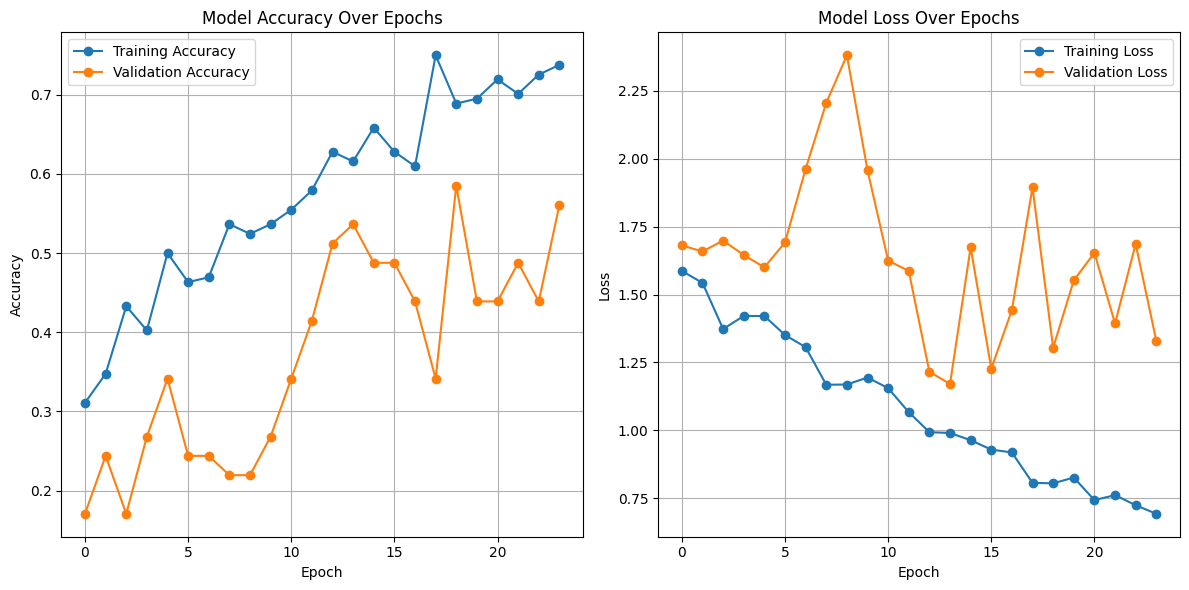

In [67]:
# ✅ Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [68]:
# ✅ Load the Best Saved Model
best_model = tf.keras.models.load_model('best_cnn_lstm_model.h5')

# ✅ Evaluate on Test Data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)

print(f"✅ Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Final Test Loss: {test_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5348 - loss: 1.1793 
✅ Final Test Accuracy: 53.66%
✅ Final Test Loss: 1.1710


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step

✅ Classification Report:
              precision    recall  f1-score   support

 Cover_Drive       0.56      0.56      0.56         9
    Cut_shot       0.75      0.38      0.50         8
     Defence       0.50      0.50      0.50         8
   Pull_Shot       0.54      0.78      0.64         9
  Sweep_Shot       0.43      0.43      0.43         7

    accuracy                           0.54        41
   macro avg       0.55      0.53      0.52        41
weighted avg       0.56      0.54      0.53        41



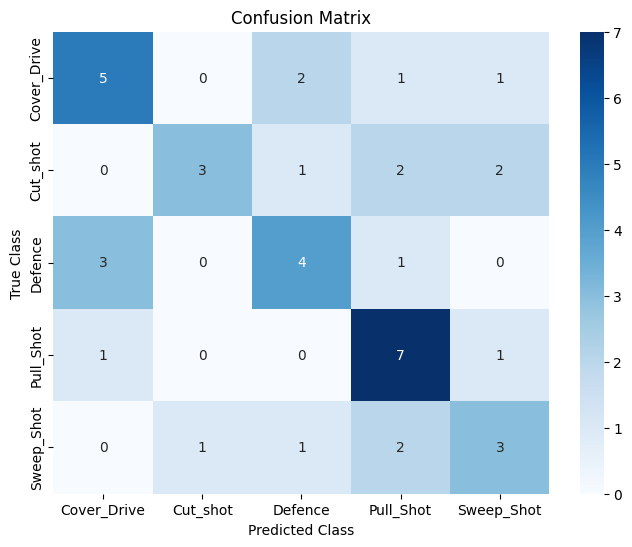

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("\n✅ Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()


In [70]:
import joblib

# ✅ Save the Best CNN + LSTM Model (already saved during training via ModelCheckpoint)
# But we ensure we reload and confirm it's saved properly
best_model = tf.keras.models.load_model('best_cnn_lstm_model.h5')

# ✅ Save the Label Encoder
label_encoder_file = "label_encoder.pkl"
joblib.dump(label_encoder, label_encoder_file)

print("✅ Model and Label Encoder saved successfully!")
print(f"Model Path        : best_cnn_lstm_model.h5")
print(f"Label Encoder Path: {label_encoder_file}")


✅ Model and Label Encoder saved successfully!
Model Path        : best_cnn_lstm_model.h5
Label Encoder Path: label_encoder.pkl


In [71]:
# Flask prediction route
model = tf.keras.models.load_model("best_cnn_lstm_model.h5")
label_encoder = joblib.load("label_encoder.pkl")
